In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score
import pymrmr
from minepy import MINE
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import joblib
from scipy.stats import rankdata

In [ ]:
tqdm.pandas() # Use tqdm.pandas() to add a progress bar.

# 1、Gene pair methods based on gene ranking relationships

### 1.1 TSP

#### 1.1.1 Train

**Steps:**
1. Import data and extract positive and negative matrices
2. Calculate number of samples and create a matrix with all gene pairwise combinations, each row containing two gene symbols
3. For positive and negative matrices, calculate the count of times the first gene is less than the second gene in each row, then divide by the number of samples (assign to columns 3 and 4)
4. Subtract column 4 from column 3 and assign the result to column 5, swap the gene positions in rows with negative values to ensure the smaller gene comes first, then take the absolute value of column 5, sort, and delete columns 3 and 4
5. Obtain the Top scoring pair

##### 1.1.1.1 Import data and extract positive and negative matrices

In [42]:
# Import data
data = pd.read_csv("./data/03_Final_data/01_train_data.csv", index_col=0)
data = data.iloc[:, :-1]
data = data.T

# Extract positive and negative matrices                     
pos_set = data.filter(like='_PTB_')
neg_set = data.filter(like='_nonPTB_')
del data
pos_set

,01_Train_Test_PTB_03,01_Train_Test_PTB_04,01_Train_Test_PTB_06,01_Train_Test_PTB_07,01_Train_Test_PTB_08,01_Train_Test_PTB_09,01_Train_Test_PTB_10,01_Train_Test_PTB_12,01_Train_Test_PTB_13,02_Train_Test_PTB_01,...,03_Train_Test_PTB_09,03_Train_Test_PTB_10,03_Train_Test_PTB_11,03_Train_Test_PTB_12,03_Train_Test_PTB_13,03_Train_Test_PTB_15,03_Train_Test_PTB_16,03_Train_Test_PTB_17,03_Train_Test_PTB_18,03_Train_Test_PTB_21
A1BG,4.435125,4.758197,4.445899,4.618962,4.420150,4.601556,4.610101,4.594324,4.415967,4.635047,...,4.453301,4.350978,4.426633,4.505209,4.352052,4.918280,4.677662,4.591781,4.443940,4.395016
A1CF,4.599350,4.509044,4.420122,4.458569,4.384252,4.501190,4.432545,4.356268,4.387820,4.528272,...,4.340317,4.430869,4.395377,4.330398,4.348418,4.355423,4.381469,4.349056,4.400686,4.675641
A2M,4.214164,4.317197,4.258403,4.232653,4.305408,4.327428,4.249705,4.225362,4.279041,4.375757,...,4.355708,4.471422,4.307597,4.283680,4.347319,4.252339,4.367983,4.305148,4.410364,4.298084
A2ML1,4.265889,4.265624,4.279280,4.256714,4.277415,4.263372,4.190286,4.237004,4.205642,4.606793,...,4.452526,4.359785,4.387455,4.299005,4.422317,4.333755,4.368539,4.510091,4.323011,4.237356
A3GALT2,4.438074,4.408685,4.282852,4.392928,4.246561,4.500439,4.390565,4.484030,4.283596,4.422470,...,4.406978,4.695729,4.417443,4.329403,4.512651,4.266734,4.301320,4.367983,4.684261,4.359319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,4.429154,4.439081,4.352526,4.419628,4.311359,4.467275,4.488764,4.283869,4.285403,4.582523,...,4.395447,4.624271,4.370471,4.298301,4.452053,4.386714,4.397029,4.378707,4.466903,4.298471
ZYG11B,8.874363,8.668623,9.331769,8.939275,9.286809,8.984254,8.726027,9.081056,8.807045,9.858484,...,9.115623,8.796806,9.236708,8.989983,8.705777,9.206913,9.217684,9.057167,9.441519,9.265028
ZYX,10.558514,10.291916,10.126720,9.841056,9.698825,10.201520,10.467883,10.156037,10.106916,11.300762,...,10.894193,10.941632,10.829912,11.000670,10.347189,10.979605,10.513702,11.266862,10.619055,10.757278
ZZEF1,7.292363,7.348779,7.536244,7.375574,7.422776,7.557392,7.550462,7.519612,7.196755,8.625986,...,8.166290,7.982794,8.032945,7.966410,8.191680,8.080650,7.985414,8.025822,7.991709,7.889634


##### 1.1.1.2 Calculate number of samples and create a matrix with all gene pairwise combinations, each row containing two gene symbols

In [43]:
# Calculate number of samples for subsequent ratio calculation
pos_nums = pos_set.shape[1]
neg_nums = neg_set.shape[1]

# Create a matrix for pairwise matches
row_names = pos_set.index.tolist()
combinations_list = list(combinations(row_names, 2))
Gene_pairs = pd.DataFrame(combinations_list, columns=['Small_gene', 'Big_gene'])
del row_names, combinations_list

##### 1.1.1.3 For positive and negative matrices, calculate the count of times the first gene is less than the second gene in each row, then divide by the number of samples (assign to columns 3 and 4)

In [44]:
# Define function to calculate the count of first gene less than second gene
def neg_calculate_counts(df):
    diff = df - neg_set
    neg_value = diff < 0
    counts = neg_value.sum(axis=1)
    
    return counts
    
def pos_calculate_counts(df):
    diff = df - pos_set
    neg_value = diff < 0
    counts = neg_value.sum(axis=1)
    
    return counts

In [45]:
# Calculate the count of times first gene is less than second gene for negative samples, divide by the number of samples, and assign to the third column
counts = neg_set.progress_apply(neg_calculate_counts, axis=1)
rows, cols = np.triu_indices(counts.shape[0], k=1)
neg_counts = counts.values[rows, cols]
del counts, rows, cols, neg_set
neg_ratios = neg_counts / neg_nums
del neg_counts, neg_nums
Gene_pairs = Gene_pairs.assign(Neg_ratio=neg_ratios)
del neg_ratios

100%|██████████| 19751/19751 [05:30<00:00, 59.76it/s]


In [46]:
# Calculate the count of times first gene is less than second gene for positive samples, divide by the number of samples, and assign to the fourth column
counts = pos_set.progress_apply(pos_calculate_counts, axis=1)
rows, cols = np.triu_indices(counts.shape[0], k=1)
pos_counts = counts.values[rows, cols]
del counts, rows, cols, pos_set
pos_ratios = pos_counts / pos_nums
del pos_counts, pos_nums
Gene_pairs = Gene_pairs.assign(Pos_ratio=pos_ratios)
del pos_ratios

100%|██████████| 19751/19751 [03:21<00:00, 98.15it/s] 


##### 1.1.1.4 Subtract column 4 from column 3 and assign the result to column 5, swap the gene positions in rows with negative values to ensure the smaller gene comes first, then take the absolute value of column 5, sort, and delete columns 3 and 4

In [47]:
# Subtract column 4 from column 3 and assign the result to column 5
Gene_pairs['diff_ratio'] = Gene_pairs['Neg_ratio'] - Gene_pairs['Pos_ratio']

# For rows with negative values, swap the gene positions to ensure the smaller gene comes first
neg_rows = Gene_pairs['diff_ratio'] < 0
Gene_pairs.loc[neg_rows, ['Small_gene', 'Big_gene']] = Gene_pairs.loc[neg_rows, ['Big_gene', 'Small_gene']].values
del neg_rows

# Take the absolute value of column 5, sort, and delete columns 3 and 4
Gene_pairs['diff_ratio'] = Gene_pairs['diff_ratio'].abs()
Gene_pairs_sorted = Gene_pairs.sort_values(by='diff_ratio', ascending=False)
del Gene_pairs
Gene_pairs_sorted.drop(columns=['Neg_ratio', 'Pos_ratio'], inplace=True)

# Save the results
Gene_pairs_sorted.to_csv("./result/02_TSP/01_Gene_pairs_sorted.csv") 
del Gene_pairs_sorted

**01_Gene_pairs_sorted.csv is too large, so only the first part is provided.**

##### 1.1.1.5 Obtain the Top scoring pair

In [49]:
TSP = {
    'Small_gene': ['ANKRD22', 'PSTPIP2', 'ANKRD22', 'ANKRD22', 'ANKRD22'],
    'Big_gene': ['KLF12', 'IL27RA', 'SMARCE1', 'ARL1', 'NPAT']
}
TSP = pd.DataFrame(TSP)
TSP.to_csv("./result/02_TSP/02_TSP.csv") 

#### 1.1.2 Test

In [121]:
# Define function
def calculate_accuracy(df, TSP):
    labels = df.iloc[:, -1]
    num_rows = df.shape[0]
    predicted_list = [0] * num_rows
    threshold = len(TSP) / 2

    # Loop through
    for i, (gene1, gene2) in TSP.iterrows():
        # Extract corresponding gene expression columns
        gene1_values = df[gene1]
        gene2_values = df[gene2]
        
        # Create comparison result: if gene1 < gene2, assign 0; otherwise, assign 1
        comparison_result = (gene1_values >= gene2_values).astype(int)
        
        # Count the number of 1 in each sample
        predicted_list = predicted_list + comparison_result
        
    # If the number of 1 is greater than half of the total number of gene pairs, classify as positive class (1), otherwise classify as negative class (0)
    predicted_labels = (predicted_list > threshold).astype(int).values

    # Calculate accuracy
    accuracy = accuracy_score(labels, predicted_labels)

    return accuracy

In [127]:
# Call function
df = pd.read_csv("./data/03_Final_data/01_train_data.csv", index_col=0)
TSP = pd.read_csv("./result/02_TSP/02_TSP.csv", index_col=0)
calculate_accuracy(df, TSP)

0.941747572815534

**train:0.942 ; test:0.909 ; valid:0.934**

### 1.2 k-TSP+SVM

#### 1.2.1 Train

**Steps:**
1. Feature encoding
2. Model construction

##### 1.2.1.1 Feature encoding

In [26]:
# Define feature encoding function
def feature_coding(df, feature_df, label, output_path):
    encoding_data_index = feature_df.apply(lambda x: x.iloc[0] + "|" + x.iloc[1], axis=1)
    encoding_data = pd.DataFrame(index=df.columns, columns=encoding_data_index)

    for gene_name in encoding_data_index:
        gene_name1, gene_name2 = gene_name.split("|")
        row1_data = df.loc[gene_name1]
        row2_data = df.loc[gene_name2]
        comparison_result = (row1_data < row2_data).astype(int) - (row1_data > row2_data).astype(int)
        encoding_data[gene_name] = comparison_result
    
    encoding_data['label'] = np.where(encoding_data.index.str.contains(label), 1, 0)

    encoding_data.to_csv(output_path)
    return encoding_data

In [52]:
# Call function to perform encoding
df = pd.read_csv("./data/03_Final_data/01_train_data.csv", index_col=0)
df = df.iloc[:, :-1]
df = df.T                                                                                                  
feature_df = pd.read_csv("./result/03_k-TSP/01_kTSP.csv")
label = '_PTB_'
output_path = "./result/05_k-TSP+SVM/01_train_feature_coding_data.csv"
encoding_data = feature_coding(df, feature_df, label, output_path)
encoding_data

,ANKRD22|KLF12,PSTPIP2|SLC4A7,GBP4|WDR75,FCGR1BP|SLAMF6,GBP6|ADAM7,label
01_Train_Test_PTB_03,-1,-1,-1,-1,-1,1
01_Train_Test_PTB_04,-1,-1,-1,-1,-1,1
01_Train_Test_PTB_06,-1,-1,1,-1,-1,1
01_Train_Test_PTB_07,-1,-1,-1,-1,-1,1
01_Train_Test_PTB_08,1,1,1,1,1,1
...,...,...,...,...,...,...
03_Train_Test_nonPTB_29,1,1,1,1,1,0
03_Train_Test_nonPTB_30,1,-1,1,1,1,0
03_Train_Test_nonPTB_31,1,1,1,1,1,0
03_Train_Test_nonPTB_32,1,1,1,1,1,0


##### 1.2.1.2 Model construction

In [ ]:
svm = SVC(probability=True, random_state=42)
param_grid = {
    'C': [0.05, 0.1, 0.15],
    'gamma': [0.05, 0.1, 0.15],
    'kernel': ['rbf', 'linear']
}
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1)
X = encoding_data.iloc[:, :-1] 
y = encoding_data.iloc[:, -1] 
grid_search.fit(X, y)
print("Optimal parameters:", grid_search.best_params_)
print("Best score on training set:", grid_search.best_score_)
best_model = grid_search.best_estimator_
joblib.dump(best_model, "./result/05_k-TSP+SVM/02_best_model.pkl")
print("Model has been saved as 'best_model.pkl'")

#### 1.2.2 Test

In [56]:
# Feature encoding
df = pd.read_csv("./data/03_Final_data/03_valid_data.csv", index_col=0)
df = df.iloc[:, :-1]
df = df.T                                                                                                  
feature_df = pd.read_csv("./result/03_k-TSP/01_kTSP.csv")
label = '_PTB_'
output_path = "./result/05_k-TSP+SVM/04_valid_feature_coding_data.csv"
encoding_data = feature_coding(df, feature_df, label, output_path)
encoding_data

,ANKRD22|KLF12,PSTPIP2|SLC4A7,GBP4|WDR75,FCGR1BP|SLAMF6,GBP6|ADAM7,label
04_Valid_PTB_01,-1,-1,-1,-1,-1,1
04_Valid_PTB_02,-1,-1,-1,-1,-1,1
04_Valid_PTB_03,-1,-1,-1,-1,-1,1
04_Valid_PTB_04,-1,-1,-1,-1,-1,1
04_Valid_PTB_05,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...
04_Valid_nonPTB_57,1,-1,1,1,-1,0
04_Valid_nonPTB_58,1,1,1,1,-1,0
04_Valid_nonPTB_59,-1,1,1,-1,-1,0
04_Valid_nonPTB_60,1,1,1,1,1,0


In [ ]:
loaded_model = joblib.load("./result/05_k-TSP+SVM/02_best_model.pkl")
print("Loaded model:", loaded_model)
X = encoding_data.iloc[:, :-1] 
y = encoding_data.iloc[:, -1] 
y_pred = loaded_model.predict(X)
accuracy = accuracy_score(y, y_pred)
accuracy

**train:0.951 ; test:0.886 ; valid:0.925**

### 1.3 REOs

#### 1.3.1 Train

**Steps:**
1. Obtain reversed gene pairs
2. Sort reversed gene pairs in descending order of reversal degree
3. Optimal reversed gene pair subset selection

##### 1.3.1.1 Obtain reversed gene pairs

In [60]:
# Define function to obtain reversed gene pairs
def reverse_gene_pairs(pos_df, neg_df, cutoff):
    def pos(x):
        sample_num = pos_df.shape[1]
        diff = x - pos_df
        big = diff > 0
        small = diff < 0
        big_num = big.sum(axis=1)  
        small_num = small.sum(axis=1)
        pos_label = (big_num > (cutoff * sample_num)) * 1
        neg_label = (small_num > (cutoff * sample_num)) * -1
        return (pos_label + neg_label)

    def neg(x):
        sample_num = neg_df.shape[1]
        diff = x - neg_df
        big = diff > 0
        small = diff < 0
        big_num = big.sum(axis=1)  
        small_num = small.sum(axis=1)
        pos_label = (big_num > (cutoff * sample_num)) * 1
        neg_label = (small_num > (cutoff * sample_num)) * -1
        return (pos_label + neg_label)

    pos_REOs = pos_df.apply(pos, axis=1)
    neg_REOs = neg_df.apply(neg, axis=1)
    
    pos_REOs[pos_REOs==0] = 100  
    neg_REOs[neg_REOs==0] = 100  
    reverse_REOs = pos_REOs + neg_REOs
    
    reverse_REOs_index = np.argwhere(abs(reverse_REOs).values==0)
    reverse_REOs_index = reverse_REOs_index.tolist() 
    uni_reverse_REOs_index = []
    for g in reverse_REOs_index:
        if g[0] < g[1]:   
            uni_reverse_REOs_index.append(g)
    
    symbol = reverse_REOs.index.values.tolist()  
    g1 = []
    g2 = []
    for i in uni_reverse_REOs_index:
        g1.append(symbol[i[0]])
        g2.append(symbol[i[1]])
        reverse_REOs_list = pd.DataFrame({"g1":g1, "g2":g2})

    return reverse_REOs_list

In [80]:
# Call function
data = pd.read_csv("./data/03_Final_data/01_train_data.csv", index_col=0)
data = data.iloc[:, :-1]
data = data.T                 
pos_set = data.filter(like='_PTB_')                 
neg_set = data.filter(like='_nonPTB_')
cutoff = 0.90
reverse_REOs_list = reverse_gene_pairs(pos_set, neg_set, cutoff)
reverse_REOs_list

,g1,g2
0,ANKRD22,ARL1
1,ANKRD22,ARMC10P1
2,ANKRD22,ARV1
3,ANKRD22,ASB1
4,ANKRD22,CA5B
5,ANKRD22,CETN3
6,ANKRD22,CRADD
7,ANKRD22,CRY1
8,ANKRD22,DFFB
9,ANKRD22,DNAJB9


In [84]:
# Define function
def adjust_gene_pairs(df, gene_pairs, output_path):
    adjusted_gene_pairs = []
    
    # Loop through all gene pairs
    for _, row in gene_pairs.iterrows():
        gene1, gene2 = row['g1'], row['g2']
        
        # Extract the expression data for the two genes
        gene1_expression = df.loc[gene1]
        gene2_expression = df.loc[gene2]
        
        # Calculate the difference and count the negatives
        diff = gene1_expression - gene2_expression
        num_negatives = (diff < 0).sum()
        
        # Check if reordering is necessary
        if num_negatives > len(df.columns) / 2:
            adjusted_gene_pairs.append([gene1, gene2])
        else:
            adjusted_gene_pairs.append([gene2, gene1])
    
    # Convert the adjusted gene pairs back to a DataFrame
    adjusted_gene_pairs_df = pd.DataFrame(adjusted_gene_pairs, columns=['g1', 'g2'])

    adjusted_gene_pairs_df.to_csv(output_path)
    return adjusted_gene_pairs_df

In [85]:
# Call function to swap gene pair positions, ensuring g1 < g2 (control group)
data = pd.read_csv("./data/03_Final_data/01_train_data.csv", index_col=0)
data = data.iloc[:, :-1]
data = data.T                 
neg_set = data.filter(like='_nonPTB_')
df = neg_set
gene_pairs = reverse_REOs_list
output_path = "./result/06_REOs/01_reverse_REOs_list.csv"
adjust_gene_pairs(df, gene_pairs, output_path)

,g1,g2
0,ANKRD22,ARL1
1,ANKRD22,ARMC10P1
2,ANKRD22,ARV1
3,ANKRD22,ASB1
4,ANKRD22,CA5B
5,ANKRD22,CETN3
6,ANKRD22,CRADD
7,ANKRD22,CRY1
8,ANKRD22,DFFB
9,ANKRD22,DNAJB9


##### 1.3.1.2 Sort reversed gene pairs in descending order of reversal degree

In [86]:
# Define function
def degree_of_reversal_rank(pos_set, neg_set, reverse_gene_pairs, output_path):
    pos_nums = pos_set.shape[1]
    neg_nums = neg_set.shape[1]
    
    def calculate_average_order_diff(data, reverse_gene_pairs, sample_nums):
        average_order_diff = []
        
        for _, row in reverse_gene_pairs.iterrows():
            gene1, gene2 = row['g1'], row['g2']
            selected_rows = data.loc[[gene1, gene2]]
            abs_diff_sum = (selected_rows.diff(axis=0).abs()).sum(axis=0).sum()
            result = abs_diff_sum / sample_nums
            average_order_diff.append(result)
            
        return average_order_diff

    pos_average_order_diff = calculate_average_order_diff(pos_set, reverse_gene_pairs, pos_nums)
    neg_average_order_diff = calculate_average_order_diff(neg_set, reverse_gene_pairs, neg_nums)
    
    result_multiply = np.multiply(pos_average_order_diff, neg_average_order_diff)
    reversal_degree = np.power(result_multiply, 0.5)
    reversal_degree = pd.Series(reversal_degree.flatten(), name='Reversal_degree') 
    feature = reverse_gene_pairs.apply(lambda x: x.iloc[0] + "|" + x.iloc[1], axis=1)
    Reversal_degree_order = pd.concat([feature, reversal_degree], axis=1, keys=['Feature', 'Reversal_degree'])
    Reversal_degree_order = Reversal_degree_order.sort_values(by='Reversal_degree', ascending=False).reset_index(drop=True)
    Reversal_degree_order = Reversal_degree_order.iloc[:, :1]
    
    Reversal_degree_order.to_csv(output_path)
    return Reversal_degree_order

In [88]:
# Call function to sort by reversal degree in descending order
df = pd.read_csv("./data/03_Final_data/01_train_data.csv", index_col=0)
df = df.iloc[:, :-1]
df = df.T                 
df_ranked = df.apply(lambda col: pd.Series(rankdata(col), index=pos_set.index))
df_ranked.columns = df.columns
pos_set = df_ranked.filter(like='_PTB_')
neg_set = df_ranked.filter(like='_nonPTB_')
reverse_gene_pairs = pd.read_csv("./result/06_REOs/01_reverse_REOs_list.csv", index_col=0)
output_path = "./result/06_REOs/02_reversal_degree_order.csv"
degree_of_reversal_rank(pos_set, neg_set, reverse_gene_pairs, output_path)

,Feature
0,ANKRD22|KLF12
1,ANKRD22|TARP
2,ANKRD22|CA5B
3,ANKRD22|THEMIS
4,ANKRD22|TC2N
5,ANKRD22|NPAT
6,ANKRD22|TMEM116
7,ANKRD22|TTC27
8,ANKRD22|USP14
9,ANKRD22|ZNF234


##### 1.3.1.3 Optimal reversed gene pair subset selection

In [129]:
# Define function
def gene_pairs_subset_selection(df, gene_pairs):
    accuracies = []
    labels = df.iloc[:, -1]  # Extract labels
    data = df.iloc[:, :-1]   # Exclude labels column

    max_odd = len(gene_pairs) if len(gene_pairs) % 2 == 1 else len(gene_pairs) - 1

    for num_pairs in range(1, max_odd + 1, 2):
        selected_pairs = gene_pairs.iloc[:num_pairs]
        predictions = []

        # Generate predictions for each sample
        for _, row in data.iterrows():
            count = 0
            for _, pair in selected_pairs.iterrows():
                gene1, gene2 = pair['Feature'].split("|")
                diff = row[gene1] - row[gene2]
                if diff < 0:
                    count += 1

            # Majority voting for label prediction
            if count > num_pairs / 2:
                predictions.append(0)
            else:
                predictions.append(1)

        # Calculate accuracy
        accuracy = np.mean(np.array(predictions) == labels.values)
        accuracies.append(accuracy)
    
    # Plot accuracies
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_odd + 1, 2), accuracies, marker='o', linestyle='-', color='b')
    plt.title("Accuracy vs Number of Gene Pairs")
    plt.xlabel("Number of Gene Pairs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.show()

    # Print accuracies
    for num_pairs, acc in zip(range(1, max_odd + 1, 2), accuracies):
        print(f"Using {num_pairs} gene pairs: Accuracy = {acc:.2f}")

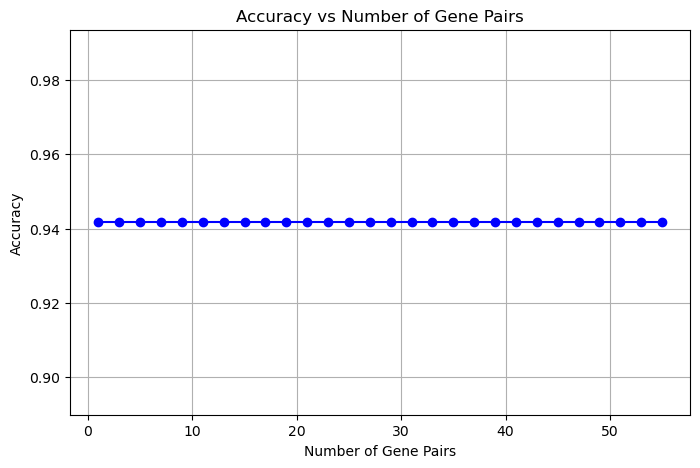

Using 1 gene pairs: Accuracy = 0.94
Using 3 gene pairs: Accuracy = 0.94
Using 5 gene pairs: Accuracy = 0.94
Using 7 gene pairs: Accuracy = 0.94
Using 9 gene pairs: Accuracy = 0.94
Using 11 gene pairs: Accuracy = 0.94
Using 13 gene pairs: Accuracy = 0.94
Using 15 gene pairs: Accuracy = 0.94
Using 17 gene pairs: Accuracy = 0.94
Using 19 gene pairs: Accuracy = 0.94
Using 21 gene pairs: Accuracy = 0.94
Using 23 gene pairs: Accuracy = 0.94
Using 25 gene pairs: Accuracy = 0.94
Using 27 gene pairs: Accuracy = 0.94
Using 29 gene pairs: Accuracy = 0.94
Using 31 gene pairs: Accuracy = 0.94
Using 33 gene pairs: Accuracy = 0.94
Using 35 gene pairs: Accuracy = 0.94
Using 37 gene pairs: Accuracy = 0.94
Using 39 gene pairs: Accuracy = 0.94
Using 41 gene pairs: Accuracy = 0.94
Using 43 gene pairs: Accuracy = 0.94
Using 45 gene pairs: Accuracy = 0.94
Using 47 gene pairs: Accuracy = 0.94
Using 49 gene pairs: Accuracy = 0.94
Using 51 gene pairs: Accuracy = 0.94
Using 53 gene pairs: Accuracy = 0.94
Using 

In [131]:
# Call function
df = pd.read_csv("./data/03_Final_data/01_train_data.csv", index_col=0)
gene_pairs = pd.read_csv("./result/06_REOs/02_reversal_degree_order.csv", index_col=0)
gene_pairs_subset_selection(df, gene_pairs)

In [132]:
# Save the optimal feature subset
selected_pairs = gene_pairs.iloc[:1]
selected_pairs.to_csv("./result/06_REOs/03_optimal_feature_subset.csv")

#### 1.3.2 Test

In [135]:
# Define function
def calculate_accuracy(df, gene_pairs):
    labels = df.iloc[:, -1]
    num_rows = df.shape[0]
    predicted_list = [0] * num_rows
    threshold = len(gene_pairs) / 2

    # Loop through
    for _, pair in gene_pairs.iterrows():
        # Extract corresponding gene expression columns
        gene1, gene2 = pair['Feature'].split("|")
        gene1_values = df[gene1]
        gene2_values = df[gene2]
        
        # Create comparison result: if gene1 < gene2, assign 0; otherwise, assign 1
        comparison_result = (gene1_values >= gene2_values).astype(int)
        
        # Count the number of  in each sample
        predicted_list = predicted_list + comparison_result
        
    # If the number of 1 is greater than half of the total number of gene pairs, classify as positive class (1); otherwise, classify as negative class (0)
    predicted_labels = (predicted_list > threshold).astype(int).values

    # Calculate accuracy
    accuracy = accuracy_score(labels, predicted_labels)

    return accuracy

In [138]:
# Call function
df = pd.read_csv("./data/03_Final_data/03_valid_data.csv", index_col=0)
gene_pairs = pd.read_csv("./result/06_REOs/03_optimal_feature_subset.csv", index_col=0)
calculate_accuracy(df, gene_pairs)

0.9433962264150944

**train:0.942 ; test:0.886 ; valid:0.943**

### 1.4 REOs+ML

#### 1.4.1 Train

**Steps:**
1. Feature encoding
2. Feature selection
3. Model construction and saving

##### 1.4.1.1 Feature encoding

In [142]:
# Define feature encoding function
def feature_coding(df, feature_df, label, output_path):
    encoding_data_index = feature_df.apply(lambda x: x.iloc[0] + "|" + x.iloc[1], axis=1)
    encoding_data = pd.DataFrame(index=df.columns, columns=encoding_data_index)

    for gene_name in encoding_data_index:
        gene_name1, gene_name2 = gene_name.split("|")
        row1_data = df.loc[gene_name1]
        row2_data = df.loc[gene_name2]
        comparison_result = (row1_data < row2_data).astype(int) - (row1_data > row2_data).astype(int)
        comparison_result = np.where(
            row1_data < row2_data, 0,      # If row1_data < row2_data, assign 0
            np.where(
                row1_data > row2_data, 1,  # If row1_data > row2_data, assign 1
                -1                         # Otherwise, assign -1                       
            )
        )
        encoding_data[gene_name] = comparison_result
    
    encoding_data['label'] = np.where(encoding_data.index.str.contains(label), 1, 0)

    encoding_data.to_csv(output_path)
    return encoding_data

In [144]:
# Call function to perform encoding
df = pd.read_csv("./data/03_Final_data/01_train_data.csv", index_col=0)
df = df.iloc[:, :-1]
df = df.T                                                                                                  
feature_df = pd.read_csv("./result/06_REOs/01_reverse_REOs_list.csv", index_col=0)
label = '_PTB_'
output_path = "./result/07_REOs+ML/01_train_feature_coding_data.csv"
encoding_data = feature_coding(df, feature_df, label, output_path)
encoding_data

,ANKRD22|ARL1,ANKRD22|ARMC10P1,ANKRD22|ARV1,ANKRD22|ASB1,ANKRD22|CA5B,ANKRD22|CETN3,ANKRD22|CRADD,ANKRD22|CRY1,ANKRD22|DFFB,ANKRD22|DNAJB9,...,CARD17P|BNIPL,CARD17P|ZNF821,PSTPIP2|CMPK1,GBP4|MAP4K1,GBP6|ZNF821,PSTPIP2|IL27RA,VAMP5|ITGAL,SRBD1|METTL3,PSTPIP2|SLC4A7,label
01_Train_Test_PTB_03,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
01_Train_Test_PTB_04,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
01_Train_Test_PTB_06,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1
01_Train_Test_PTB_07,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
01_Train_Test_PTB_08,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03_Train_Test_nonPTB_29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
03_Train_Test_nonPTB_30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
03_Train_Test_nonPTB_31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
03_Train_Test_nonPTB_32,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


##### 1.4.1.2 Feature selection

In [148]:
# Call function to perform feature sorting (function located in 1.5.1.3)
selected_methods = ['mRMR']
feature_importance_order = feature_importance_rank(encoding_data, selected_methods)
feature_importance_order.to_csv("./result/07_REOs+ML/02_feature_importance_order.csv")

22|TMEM116 	 0.845
19 	 46 	 ANKRD22|WDR73 	 0.840
20 	 32 	 ANKRD22|SNAP29 	 0.831
21 	 2 	 ANKRD22|ARMC10P1 	 0.824
22 	 36 	 ANKRD22|TC2N 	 0.815
23 	 23 	 ANKRD22|PHF20 	 0.811
24 	 9 	 ANKRD22|DFFB 	 0.809
25 	 6 	 ANKRD22|CETN3 	 0.804
26 	 7 	 ANKRD22|CRADD 	 0.800
27 	 8 	 ANKRD22|CRY1 	 0.795
28 	 5 	 ANKRD22|CA5B 	 0.792
29 	 19 	 ANKRD22|NME6 	 0.786
30 	 27 	 ANKRD22|RAD23B 	 0.783
31 	 38 	 ANKRD22|THEMIS 	 0.780
32 	 15 	 ANKRD22|ITPR1 	 0.779
33 	 33 	 ANKRD22|SNAPC3 	 0.776
34 	 35 	 ANKRD22|TBC1D31 	 0.775
35 	 14 	 ANKRD22|HIBCH 	 0.774
36 	 45 	 ANKRD22|USP14 	 0.773
37 	 4 	 ANKRD22|ASB1 	 0.770
38 	 47 	 ANKRD22|ZNF234 	 0.768
39 	 37 	 ANKRD22|TCF4 	 0.767
40 	 17 	 ANKRD22|MIOS 	 0.765
41 	 24 	 ANKRD22|PPRC1 	 0.762
42 	 43 	 ANKRD22|TTC27 	 0.762
43 	 22 	 ANKRD22|NRAS 	 0.758
44 	 30 	 ANKRD22|SLX4IP 	 0.757
45 	 13 	 ANKRD22|GGCT 	 0.757
46 	 39 	 ANKRD22|TIMM29 	 0.756
47 	 40 	 ANKRD22|TMEM106C 	 0.755
48 	 11 	 ANKRD22|GALNT4 	 0.754
49 	 44 	 ANKRD22|TULP

In [160]:
# Define feature selection function
def selection(X, y, orders, model, n_split):
    auc_list = [] 
    feature_len = orders.shape[0]
    cv = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=42)
    
    for i in range(1, feature_len+1):
        selected_features = orders.iloc[:i, 0].tolist() 
        X_select = X.loc[:, selected_features]
        y_pred = cross_val_predict(model, X_select, y, cv=cv, method="predict_proba")[:, 1]
        pred_auc = roc_auc_score(y, y_pred)
        auc_list.append(pred_auc)
        
    auc_series = pd.Series(auc_list, index=range(1, feature_len+1))
    plt.figure(figsize=(8, 5))
    plt.plot(auc_series.index, auc_series.values, marker='o', linestyle='-', color='b')
    plt.title("AUC vs Number of Gene Pairs")
    plt.xlabel("Number of Gene Pairs")
    plt.ylabel("AUC")
    plt.grid()
    plt.show()

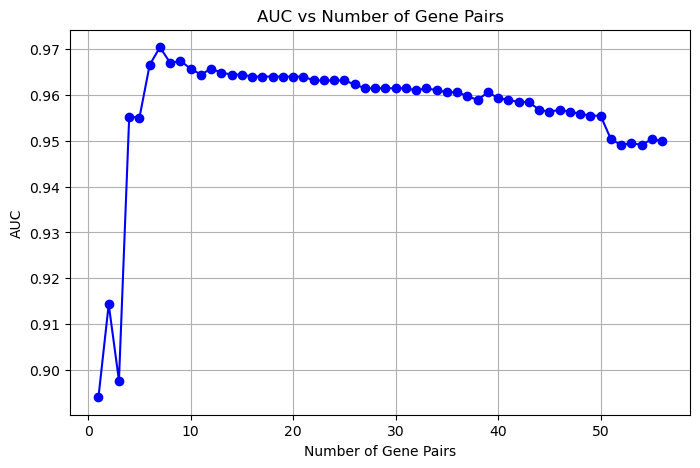

In [161]:
# Call function
X = encoding_data.iloc[:, :-1]
y = encoding_data.iloc[:, -1]
orders = feature_importance_order
model = SVC(probability=True, random_state=42)
n_split = 5
selection(X, y, orders, model, n_split)

##### 1.4.1.3 Model construction and saving

In [ ]:
svm = SVC(probability=True, random_state=42)
param_grid = {
    'C': [0.05, 0.1, 0.15],
    'gamma': [0.05, 0.1, 0.15],
    'kernel': ['rbf', 'linear']
}
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1)
X = encoding_data.iloc[:, :-1] 
y = encoding_data.iloc[:, -1] 
selected_pairs = feature_importance_order.iloc[:7, 0].tolist() 
X_select = X.loc[:, selected_pairs]
grid_search.fit(X_select, y)
print("Optimal parameters:", grid_search.best_params_)
print("Best score on training set:", grid_search.best_score_)
best_model = grid_search.best_estimator_
joblib.dump(best_model, "./result/07_REOs+ML/03_best_model.pkl")
print("Model has been saved as 'best_model.pkl'")

#### 1.4.2 Test

In [174]:
# Feature encoding
df = pd.read_csv("./data/03_Final_data/03_valid_data.csv", index_col=0)
df = df.iloc[:, :-1]
df = df.T                                                                                                  
feature_df = pd.read_csv("./result/06_REOs/01_reverse_REOs_list.csv", index_col=0)
label = '_PTB_'
output_path = "./result/07_REOs+ML/05_vallid_feature_coding_data.csv"
encoding_data = feature_coding(df, feature_df, label, output_path)
encoding_data

,ANKRD22|ARL1,ANKRD22|ARMC10P1,ANKRD22|ARV1,ANKRD22|ASB1,ANKRD22|CA5B,ANKRD22|CETN3,ANKRD22|CRADD,ANKRD22|CRY1,ANKRD22|DFFB,ANKRD22|DNAJB9,...,CARD17P|BNIPL,CARD17P|ZNF821,PSTPIP2|CMPK1,GBP4|MAP4K1,GBP6|ZNF821,PSTPIP2|IL27RA,VAMP5|ITGAL,SRBD1|METTL3,PSTPIP2|SLC4A7,label
04_Valid_PTB_01,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,0,1,1
04_Valid_PTB_02,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,1,1,1,1,1,1
04_Valid_PTB_03,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
04_Valid_PTB_04,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
04_Valid_PTB_05,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
04_Valid_nonPTB_57,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
04_Valid_nonPTB_58,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
04_Valid_nonPTB_59,1,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
04_Valid_nonPTB_60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
loaded_model = joblib.load("./result/07_REOs+ML/03_best_model.pkl")
print("Loaded model:", loaded_model)
X = encoding_data.iloc[:, :-1] 
y = encoding_data.iloc[:, -1] 
selected_pairs = feature_importance_order.iloc[:7, 0].tolist() 
X_select = X.loc[:, selected_pairs]
y_pred = loaded_model.predict(X_select)
accuracy = accuracy_score(y, y_pred)
accuracy

**train:0.961 ; test:0.909 ; valid:0.953**

### 1.5 TSP+ML

#### 1.5.1 Train

**Steps:**
1. Preliminary feature extraction
2. Feature encoding
3. Feature importance ranking
4. Feature, algorithm, and optimal parameter selection
5. Model construction

##### 1.5.1.1 Preliminary feature extraction

In [6]:
# Define feature extraction function
def gene_pairs_extraction(input_file, threshold, remove_duplicates, output_file):
    # Read data
    data = pd.read_csv(input_file, index_col=0)
    
    # Set threshold
    data = data[data['diff_ratio'] > threshold]
    
    # Define deduplication function
    def duplicate_removal(matrix):
        result_matrix = []
        while len(matrix) > 0:
            current_values = matrix.iloc[0, :2].values
            selected_rows = np.any(np.isin(matrix.iloc[:, :2].values, current_values), axis=1)
            result_matrix.append(matrix.iloc[0, :].values)
            matrix = matrix[~selected_rows]
        result_matrix = np.array(result_matrix)
        result_df = pd.DataFrame(result_matrix, columns=matrix.columns)
        return result_df

    # Check if deduplication is needed
    if remove_duplicates:
        data = duplicate_removal(data)
    else:
        data = data

    # Save results
    data.to_csv(output_file, index=False)

    return data

In [ ]:
# Call function to perform feature extraction
input_file = "./result/02_TSP/01_Gene_pairs_sorted.csv"
threshold = 0.82
remove_duplicates = True
output_file = "./result/08_TSP+ML/01_gene_pairs.csv"
gene_pairs_extraction(input_file, threshold, remove_duplicates, output_file)

##### 1.5.1.2 Feature encoding

In [8]:
# Define feature encoding function
def feature_coding(df, feature_df, label, output_path):
    encoding_data_index = feature_df.apply(lambda x: x.iloc[0] + "|" + x.iloc[1], axis=1)
    encoding_data = pd.DataFrame(index=df.columns, columns=encoding_data_index)

    for gene_name in encoding_data_index:
        gene_name1, gene_name2 = gene_name.split("|")
        row1_data = df.loc[gene_name1]
        row2_data = df.loc[gene_name2]
        comparison_result = (row1_data < row2_data).astype(int) - (row1_data > row2_data).astype(int)
        encoding_data[gene_name] = comparison_result
    
    encoding_data['label'] = np.where(encoding_data.index.str.contains(label), 1, 0)

    encoding_data.to_csv(output_path)
    return encoding_data

In [9]:
# Call function to perform encoding
df = pd.read_csv("./data/03_Final_data/01_train_data.csv", index_col=0)
df = df.iloc[:, :-1]
df = df.T                                                                                                  
feature_df = pd.read_csv("./result/08_TSP+ML/01_gene_pairs.csv")
label = '_PTB_'
output_path = "./result/08_TSP+ML/02_train_feature_coding_data.csv"
encoding_data = feature_coding(df, feature_df, label, output_path)
encoding_data

,ANKRD22|KLF12,PSTPIP2|IL27RA,VAMP5|ITGAL,GBP6|ZNF821,IL15|WDSUB1,GBP4|NUP88,CARD17P|BNIPL,SRBD1|METTL3,BATF2|SLFN13,GBP2|KLF2,FCGR1BP|PTPRC,FCGR1A|ST6GAL1,label
01_Train_Test_PTB_03,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
01_Train_Test_PTB_04,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
01_Train_Test_PTB_06,-1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1
01_Train_Test_PTB_07,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
01_Train_Test_PTB_08,1,1,-1,1,-1,1,-1,-1,1,-1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
03_Train_Test_nonPTB_29,1,1,1,1,1,1,1,1,1,1,1,1,0
03_Train_Test_nonPTB_30,1,1,1,1,1,1,1,1,-1,1,1,1,0
03_Train_Test_nonPTB_31,1,1,1,1,1,1,1,1,1,1,1,1,0
03_Train_Test_nonPTB_32,1,1,1,1,1,1,1,1,1,1,1,1,0


##### 1.5.1.3 Feature importance ranking

In [11]:
# MIC
def MIC_score(X, y):
    mine = MINE(alpha=0.6, c=15)
    mine.compute_score(X, y)
    return mine.mic()

def MIC_feature_importance_rank(df):
    feature_list = []
    MIC_list = []
    selected_columns = df.columns[:-1]
    
    for column_name in selected_columns:
        MIC = MIC_score(df[column_name], df["label"])
        feature_list.append(column_name)
        MIC_list.append(MIC)
        
    MIC_order = pd.DataFrame({'MIC':feature_list, 'MIC_score':MIC_list})
    MIC_order = MIC_order.sort_values(by="MIC_score", ascending=False).reset_index(drop=True)
    MIC_order = MIC_order.iloc[:, :1]
    
    return MIC_order

In [12]:
# Chi2
def Chi2_feature_importance_rank(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    X_shifted = X - X.min()
    scores, _ = chi2(X_shifted, y)
    Chi2_order = pd.DataFrame({'Chi2': X.columns, 'Chi2_score': scores})
    Chi2_order = Chi2_order.sort_values(by='Chi2_score', ascending=False).reset_index(drop=True)
    Chi2_order = Chi2_order.iloc[:, :1]
    
    return Chi2_order

In [145]:
# mRMR
def mRMR_feature_importance_rank(df):
    df = pd.concat([df.iloc[:, -1], df.iloc[:, :-1]], axis=1)
    feature_len = df.shape[1] - 1
    mRMR_order = pymrmr.mRMR(df, 'MIQ', feature_len)
    mRMR_order = pd.DataFrame({'mRMR': mRMR_order})
    
    return mRMR_order

In [14]:
# RF
def RF_feature_importance_rank(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X, y)
    feature_importance = clf.feature_importances_
    RF_order = pd.DataFrame({'RF': X.columns, 'RF_score': feature_importance})
    RF_order = RF_order.sort_values(by='RF_score', ascending=False).reset_index(drop=True)
    RF_order = RF_order.iloc[:, :1]

    return RF_order

In [146]:
# Define feature ranking function
def feature_importance_rank(df, methods):
    result_df = pd.DataFrame()

    if 'MIC' in methods:
        MIC_order = MIC_feature_importance_rank(df)
        result_df = pd.concat([result_df, MIC_order], axis=1)

    if 'Chi2' in methods:
        Chi2_order = Chi2_feature_importance_rank(df)
        result_df = pd.concat([result_df, Chi2_order], axis=1)

    if 'mRMR' in methods:
        mRMR_order = mRMR_feature_importance_rank(df)
        result_df = pd.concat([result_df, mRMR_order], axis=1)

    if 'RF' in methods:
        RF_order = RF_feature_importance_rank(df)
        result_df = pd.concat([result_df, RF_order], axis=1)

    return result_df

In [16]:
# Call function to perform feature ranking
selected_methods = ['MIC', 'Chi2', 'mRMR', 'RF']
feature_importance_order = feature_importance_rank(encoding_data, selected_methods)
feature_importance_order.to_csv("./result/08_TSP+ML/03_feature_importance_order.csv")

##### 1.5.1.4 Feature, algorithm, and optimal parameter selection

In [17]:
# Define function
def selection(X, y, algorithms, multiple_orders, n_split, colors, row_nums=None, col_nums=None, njobs=None, save_figure=None, output_path=None):
    results = pd.DataFrame()
    plt.figure(figsize=(15, 10))
    color_index = 0
    sharey = None
    
    cv = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=42)
    feature_len = multiple_orders.shape[0]

    for i, (algorithm_name, algorithm_params) in enumerate(algorithms.items(), start=1):
        algorithm_results = pd.DataFrame()
        ax = plt.subplot(row_nums, col_nums, i, sharey=sharey)
        
        estimator = algorithm_params['estimator']
        param_grid = algorithm_params['param_grid']
        grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring="roc_auc", cv=cv, n_jobs=njobs)
            
        for order_name, order_data in multiple_orders.items():
            parameters_list = []  
            auc_list = [] 
            feature_num_list = [] 
   
            for j in tqdm(range(1, feature_len+1), desc=f'{algorithm_name}: {order_name}'):
                selected_features = order_data.values[:j]
                X_select = X.loc[:, selected_features]
                grid.fit(X_select, y)
                best_model = grid.best_estimator_
                y_pred = cross_val_predict(best_model, X_select, y, cv=cv, method="predict_proba")[:, 1]
                pred_auc = roc_auc_score(y, y_pred)
                auc_list.append(pred_auc)
    
                feature_num = X_select.shape[1]
                feature_num_list.append(feature_num)
                parameters_list.append(grid.best_params_)
    
            result_temp = pd.DataFrame({algorithm_name+"_"+order_name:order_data.values, algorithm_name+"_"+order_name+"_"+"Feature_num":feature_num_list, 
                                        algorithm_name+"_"+order_name+"_"+"Parameters":parameters_list, algorithm_name+"_"+order_name+"_"+"Auc":auc_list})
            algorithm_results = pd.concat([algorithm_results, result_temp], axis=1)

            auc_series = pd.Series(auc_list, index=range(1, feature_len+1))
            color = colors[color_index % len(colors)]
            plt.plot(auc_series.index, auc_series.values, color=color, label=f'{order_name}', linewidth=2)
            color_index += 1
            
        results = pd.concat([results, algorithm_results], axis=1)

        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc="lower right", fontsize=16) 
        plt.title(f'{algorithm_name}', fontsize=20)
        plt.xlabel("Number of gene pairs", fontsize=18)
        plt.ylabel("AUC", fontsize=18)
        plt.xticks(np.arange(1, feature_len+1), np.arange(1, feature_len+1), fontsize=16)
        plt.yticks(fontsize=16)

        for spine in ax.spines.values():
            spine.set_linewidth(2)  
            
        if i == 1:
            sharey = ax

    plt.tight_layout()
    
    if save_figure and output_path:
        plt.savefig(output_path, format='pdf', dpi=300, bbox_inches='tight')    
        print(f"Plot saved as {output_path}")
    plt.show()

    return results

Support Vector Machine: RF: 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]


Plot saved as ./result/08_TSP+ML/04_selection_AUC.pdf


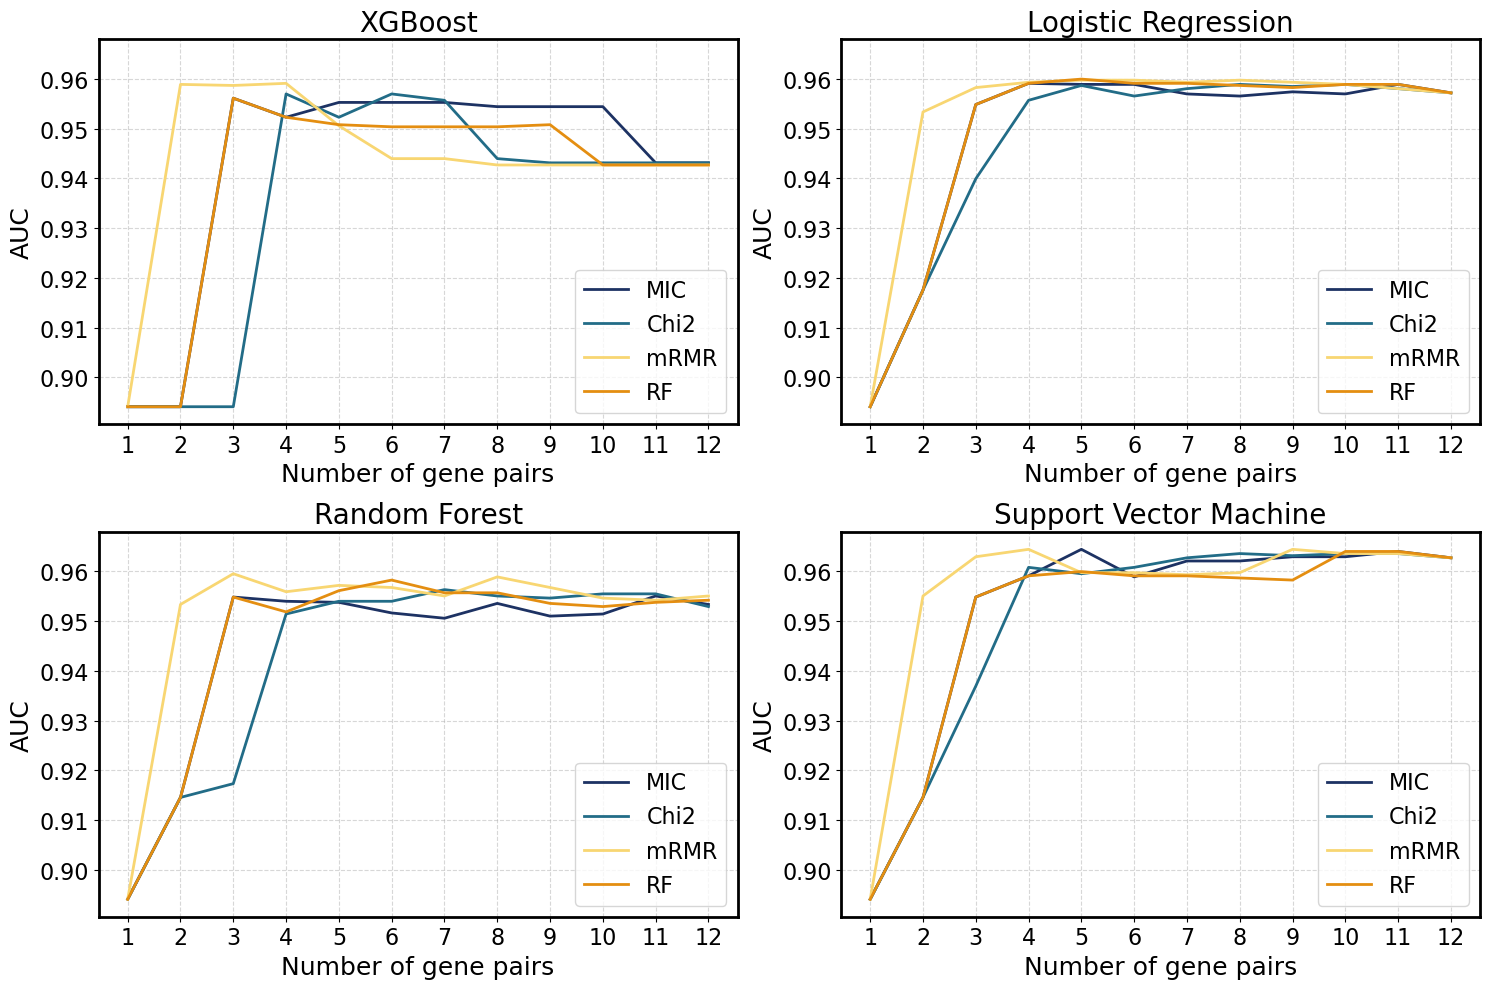

In [18]:
# Call function
X = encoding_data.iloc[:, :-1]
y = encoding_data.iloc[:, -1]
algorithms = {
    'XGBoost': {
        'estimator': XGBClassifier(random_state=42),
        'param_grid': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6], 'min_child_weight': [1, 2], 'subsample': [0.8, 1.0]} 
    },
    'Logistic Regression': {
        'estimator': LogisticRegression(random_state=42),
        'param_grid': {'C': [0.05, 0.1, 0.15]}
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(random_state=42),
        'param_grid': {'n_estimators': [50, 100], 'max_depth': [5, 10], 'min_samples_split': [3, 4], 'min_samples_leaf': [2, 3]}  
    },
    'Support Vector Machine': {
        'estimator': SVC(probability=True, random_state=42),
        'param_grid': {'gamma': [0.05, 0.1, 0.15], 'C': [0.05, 0.1, 0.15]}
    }
}
multiple_orders = feature_importance_order.iloc[:12]
n_split = 5
colors = ["#1d3263", "#226c87", "#f8d672", "#e48e11"]
row_nums = 2
col_nums = 2
njobs = -1
save_figure = True
output_path = './result/08_TSP+ML/04_selection_AUC.pdf'
feature_selection_AUC_result = selection(X, y, algorithms, multiple_orders, n_split, colors, row_nums, col_nums, njobs, save_figure, output_path)
feature_selection_AUC_result.to_csv("./result/08_TSP+ML/05_selection_AUC.csv")

##### 1.5.1.5 Model construction

In [19]:
SVM_params = {'C': 0.05, 'gamma': 0.05, 'probability': True, 'random_state': 42}
SVM_model = SVC(**SVM_params)
best_features = ["PSTPIP2|IL27RA", "CARD17P|BNIPL", "SRBD1|METTL3", "IL15|WDSUB1", "label"]
final_train_data = encoding_data[best_features]
X = final_train_data.iloc[:, :-1] 
y = final_train_data.iloc[:, -1]  
SVM_model.fit(X, y)
joblib.dump(SVM_model, './result/08_TSP+ML/06_SVM_model.joblib')

['./result/08_TSP+ML/06_SVM_model.joblib']

#### 1.5.2 Test

In [23]:
# Feature encoding
df = pd.read_csv("./data/03_Final_data/02_test_data.csv", index_col=0)
df = df.iloc[:, :-1]
df = df.T
feature_df = pd.read_csv("./result/08_TSP+ML/01_gene_pairs.csv")
label = '_PTB_'
output_path = "./result/08_TSP+ML/07_test_feature_coding_data.csv"
test_encoding_data = feature_coding(df, feature_df, label, output_path)
final_test_data = test_encoding_data[best_features]
final_test_data

,PSTPIP2|IL27RA,CARD17P|BNIPL,SRBD1|METTL3,IL15|WDSUB1,label
01_Train_Test_PTB_01,-1,-1,-1,-1,1
01_Train_Test_PTB_02,-1,-1,-1,-1,1
01_Train_Test_PTB_05,-1,-1,-1,-1,1
01_Train_Test_PTB_11,-1,-1,-1,1,1
01_Train_Test_nonPTB_04,1,-1,1,1,0
01_Train_Test_nonPTB_05,1,1,1,1,0
01_Train_Test_nonPTB_06,1,1,-1,-1,0
01_Train_Test_nonPTB_07,1,1,1,1,0
01_Train_Test_nonPTB_11,1,1,1,1,0
01_Train_Test_nonPTB_15,1,1,1,1,0


In [25]:
# Calculate accuracy
model = joblib.load('./result/08_TSP+ML/06_SVM_model.joblib')
X = final_valid_data.iloc[:, :-1] 
y = final_valid_data.iloc[:, -1]  
y_pred = model.predict(X)
accuracy = accuracy_score(y, y_pred)
accuracy

0.9528301886792453

**train:0.971 ; test:0.932 ; valid:0.953**